<a href="https://colab.research.google.com/github/riccardomarin/Diff-FMAPs-PyTorch/blob/main/esercizi/ex6/ex6_full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Benvenuti alla sesta esercitazione di Metodi Numerici!

Oggi esploreremo alcune applicazioni reali della fattorizzazione SVD e della approssimazione low-rank!

----
Alcuni credits: 
- Per i francobolli:
https://courses.seas.harvard.edu/courses/am205/g_act/svd_slides.pdf
- Per procustes:
https://simonensemble.github.io/2018-10/orthogonal-procrustes
- Per ICP:
https://github.com/niosus/notebooks/blob/master/icp.ipynb
- Per video-background removal: https://nbviewer.org/github/fastai/numerical-linear-algebra/blob/master/nbs/3.%20Background%20Removal%20with%20Robust%20PCA.ipynb#


In [ ]:
from PIL import Image
from scipy.linalg import svd 
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import animation, rc
from math import sin, cos, atan2, pi
from IPython.display import display, Math, Latex, Markdown, HTML
!pip install scikit-video

!wget https://anotherimg-dazedgroup.netdna-ssl.com/1028/azure/another-prod/400/0/400686.jpg -O ali.jpg
!wget https://raw.githubusercontent.com/erodola/NumMeth-s2-2022/main/esercizi/ex6/111.mp4 -O 111.mp4
!wget https://raw.githubusercontent.com/erodola/NumMeth-s2-2022/main/esercizi/ex6/point_cloud.txt -O point_cloud.txt

f = "https://raw.githubusercontent.com/jandrejevic12/svd_files/master/stamps/"
N = 22 # the number of images
ims = [0]*N
for i in range(N):
    name = f + "im_{:02d}.jpg".format(i)
    !wget $name
    print(name)

     |████████████████████████████████| 2.3 MB 7.9 MB/s 
--2022-04-12 20:18:03--  https://anotherimg-dazedgroup.netdna-ssl.com/1028/azure/another-prod/400/0/400686.jpg
Resolving anotherimg-dazedgroup.netdna-ssl.com (anotherimg-dazedgroup.netdna-ssl.com)... 94.31.29.248
Connecting to anotherimg-dazedgroup.netdna-ssl.com (anotherimg-dazedgroup.netdna-ssl.com)|94.31.29.248|:443... connected.
HTTP request sent, awaiting response... 200 OK
Cookie coming from anotherimg-dazedgroup.netdna-ssl.com attempted to set domain to images.anothermag.com
Length: 151868 (148K) [image/jpeg]
Saving to: ‘ali.jpg’

ali.jpg             100%[===================>] 148.31K  --.-KB/s    in 0.05s   

2022-04-12 20:18:03 (2.83 MB/s) - ‘ali.jpg’ saved [151868/151868]

--2022-04-12 20:18:03--  https://raw.githubusercontent.com/erodola/NumMeth-s2-2022/main/esercizi/ex6/111.mp4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.gi

# Image Compression

Una prima applicazione di SVD è quella di comprimere i dati, e lo mostreremo su un'immagine. Anche se può sembrare controintuitivo che una matrice possa essere più economicamente salvata con l'uso di tre matrici, mostreremo che la low-rank approximation ci permette di troncare abbastanza valori da risultare conveniente!

Carichiamo l'immagine

*Muhammad Ali - Gordon Parks, Miami Beach, Florida, 1970*

(700, 1028)


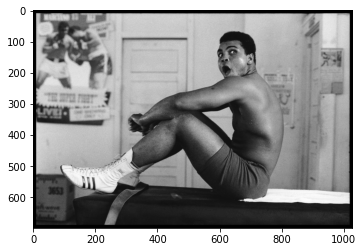

In [ ]:
# Apre l'immagine
image = Image.open('./ali.jpg')

# Normalizziamola tra 0 e 1
image = (np.array(image) / np.max(np.array(image)))[:,:,0]
plt.imshow(image[:,:],cmap='gray')
print(image.shape)

Questa immagine non è altro che una matrice, quindi possiamo trovare la sua approssimazione SVD. Per farlo ci avvaliamo della funzione [scipy.linalg.svd](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.svd.html) che abbiamo già importanto sopra.

In [ ]:
# NOTA: Dalla documentazione ritorna U, s, Vh tale che:
# A == U @ S @ Vh, dove S è una matrice di zeri con s sulla diagonale principale
# Nota: s è ritornata in ordine decrescente.
media = np.mean(image)
u, s, vh = svd(image - media, full_matrices=True) # se non lo mettete le matrici
                                                  # non avranno le colonne\righe
                                                  # tutte a zero; nel nostro caso
                                                  # cambia la dimensione di vh

# Costruiamo quindi S, che noi chiameremo Sigma
m = image.shape[0]; n = image.shape[1];
sigma = np.zeros((m, n))
for i in range(min(m, n)):
    sigma[i, i] = s[i]

# Controlliamo le dimensioni; notate che 
# Image = (700 x 1028)
# Quindi  U @ S @ Vh deve essere coerente con questo

print(u.shape)
print(sigma.shape)
print(vh.shape)

(700, 700)
(700, 1028)
(1028, 1028)


ESERCIZIO 1: per fare la low-rank approximation possiamo usare la decomposizione fornita dalla SVD e considerare solo i primi k-valori. 

In questo caso quallo che dovrete fare è utilizzare solo il 5% dei valori della fattorizzazione SVD per ricostruire l'immagine.

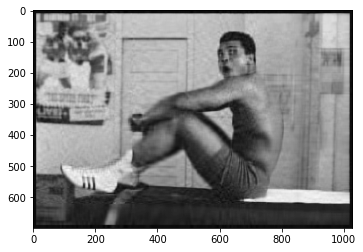

In [ ]:
# Percentuale di coefficienti da utilizzare
perc = 5

# Seleziono quinidi i primi k valori
k = int(len(s) * perc / 100 )

# Low-rank approximation
sigma_masked = sigma.copy()
sigma_masked[sigma_masked < s[k]] = 0

low_rank = (np.dot(u, np.dot(sigma_masked, vh)) + media)
plt.imshow(low_rank,cmap='gray')

Esercizio 2: Mostrare con un plot quanto cambiano, al variare di K:

1) L'errore di ricostruzione

2) Il costo di memoria

100% (700 of 700) |######################| Elapsed Time: 0:00:41 Time:  0:00:41


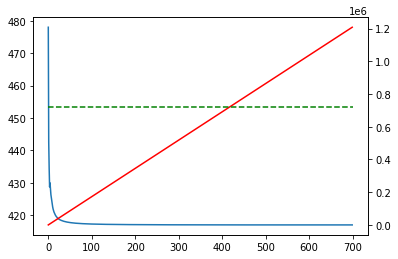

In [ ]:
from progressbar import progressbar

# Lista degli errori al variare di K
error = []

# Lista della quantità di memoria necessaria al variare di K
dim = []

for k in progressbar(np.arange(0,sigma.shape[0])):
  # Errore = | Immagine - Ricostruzione |_'fro'
  error.append(np.linalg.norm(image - (np.dot(u[:,0:k], np.dot(sigma[0:k,0:k], vh[0:k,:]))),'fro'))

  # Dim = quantità di numeri per rappresentare l'immagine
  dim.append(u[:,0:k].shape[0]*u[:,0:k].shape[1] + sigma[0:k,0:k].shape[0] + vh[0:k,:].shape[0] * vh[0:k,:].shape[1] )
  
# Ci serviranno due assi, visto che errore e memoria stanno su due scale diverse
fig, ax1 = plt.subplots()
ax1.plot(error)

ax2 = ax1.twinx() 
ax2.plot(dim,color='r')

# Traccio una linea tratteggiata per segnare il costo in memoria dell'immagine 
# iniziale.
dim_image = image.shape[0] * image.shape[1]
ax2.plot([0, len(s)],[dim_image, dim_image],'g--')

# Denoising

La low-rank approximation può anche essere utilizzata per rimuovere il rumore da una collezione di dati. 

Consideriamo molte immagini simili (ad esempio dei francobolli), su cui possono comparire elementi di rumore (come graffi, timbri, pieghe). Questi ultimi saranno utili per ricostruire solo alcuni francobolli, ma sarà importante catturare gli attributi che più caratterizzano la maggior parte dei francobolli.

Con questa idea, organizzando i nostri dati in una matrice (ad esempio, salvando i francobolli in vettori e concatenandoli in una matrice) possiamo utilizzare la low-rank approximation della SVD per escludere le feature sporadiche e poco utili a rappresentare la popolazione.

Carichiamo i francobolli

In [ ]:
def load_data():
    print("loading data ...")
    N = 22 # the number of images
    ims = [0]*N
    for i in range(N):
        name = "im_{:02d}.jpg".format(i)
        ims[i] = np.array(Image.open(name))
    
    ims = np.array(ims).astype(np.float)/255. 
    print("load complete!")
    return ims

francobolli = load_data()
N, m, n, p = francobolli.shape

loading data ...
load complete!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


Visualizziamo i nostri dati

(22, 170, 139, 3)


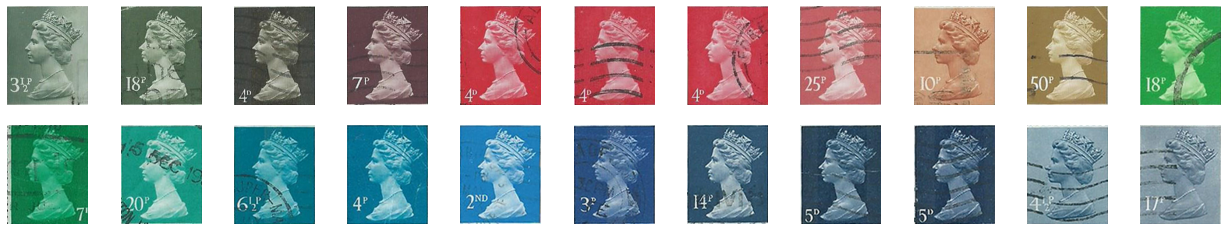

In [ ]:
# Visualize the data in a grid:
def plot_data(data):
    m = 2
    n = len(data)//m
    fig, axes = plt.subplots(m, n, figsize=(2*n,2*m))
    for i,ax in enumerate(axes.flat):
        ax.imshow(data[i])
        ax.axis('off')
    plt.show()

print(francobolli.shape)
plot_data(francobolli)

Notiamo che i francobolli hanno i segni dei timbri postali, ma l'immagine sottostante è molto simile tra tutte. 

La dimensione del dataset è una matrice (22, 170, 139, 3):
- 22  -> numero di francobolli (N)
- 170 -> altezza di un francobollo (m)
- 139 -> larghezza di un francobollo (n)
- 3   -> numero di canali RGB (p)

Esercizio 3:
- Per prima cosa portiamo la matrice del dataset nella forma N x (m * n * p); ovvero ogni francobollo diventerà una riga, e avremo N righe (cioè tante quanti i francobolli). Ogni riga avrà le feature di quel francobollo
- Calcoliamo la media dei francobolli e la sottraiamo a tutti
- Facciamo SVD

In [ ]:
# Reshape dei dati m*n*p x N:
S = francobolli.reshape(N, m*n*p).T

# Calcolo della media
Sm = np.mean(S, axis=1, keepdims=True) # Anche se è un vettore, mantenetelo 2-dimensionale

# Centriamo la matrice
A = S - Sm

# Calcoliamo SVD
U, s, Vt = svd(A, full_matrices=False) # Dovremo utilizzare a False perché se no
                                       # andremo out of memory

print(U.shape)
print(s.shape)
print(Vt.shape)

(70890, 22)
(22,)
(22, 22)


- Usare low-rank approximation per ricostruire un francobollo e constatare la rimozione del rumore. Visto che le matrici non possono essere tenute in memoria con le dimensioni adatte alle operazioni matriciali, dobbiamo ricotruire in modo esplicito. In particolare:
$ A_r = \sum U_i s_i V^{T}_i$



In [ ]:
# Rango della ricostruzione
r = 1

sigma_masked = sigma.copy()
#

Ar = np.zeros(A.shape)
for k in range(A.shape[1]):
  Ar[:,k] = np.sum([U[:,i]*s[i]*Vt[i,k] for i in range(r)], axis=0)


# Aggiungiamo la media
Ar += Sm



Tronchiamo i valori in range validi perché il low-rank non sa che i valori possono stare solo tra 0 e 1

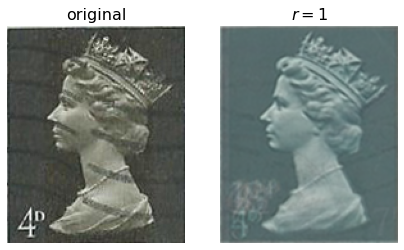

In [ ]:
# Indice dell'immagine
index = 2

# riportiamo il francobollo a una matrice di dimensione m x n x p
imr = Ar[:,index].reshape(m,n,p)

# Tronchiamo in un range valido
imr[imr<0] = 0; imr[imr>1]=1

# Mostriamo l'immagine originale e quella compressa
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(7,4))
ax1.imshow(francobolli[index])
ax1.set_title("original", size=16)
ax1.axis("off")

ax2.imshow(imr)
ax2.set_title("$r={:d}$".format(r), size=16)
ax2.axis("off")
plt.show()

Ora andiamo a disporre i nostri dati come le prime due direzioni delle PCA, e vediamo come si comportano. Quali sono semanticamente le caratteristiche che distribuiscono i francobolli lungo le due direzioni?

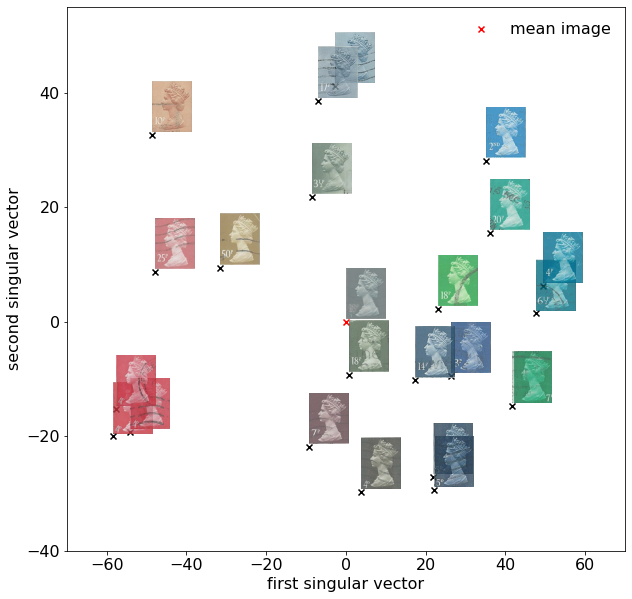

In [ ]:
# Proiettiamo ogni immagine nello spazio delle prime due dimensioni, date da U
coords = np.dot(U[:,:2].T,A)


# Visualizziamo le coordinate ottenute
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.scatter(coords[0], coords[1], color='k', marker='x')
# plot each image at its corresponding location
for i in range(N):
    axin = ax.inset_axes([coords[0,i],coords[1,i],10,10],transform=ax.transData)
    axin.imshow(francobolli[i],alpha=0.8)
    axin.axis('off')

# also plot the mean, which lies at the origin.
ax.scatter(0, 0, color='r', marker='x', label='mean image')
axin = ax.inset_axes([0,0,10,10],transform=ax.transData)
axin.imshow(Sm.reshape(m,n,p), alpha=0.8)
axin.axis('off')

ax.set_xlabel('first singular vector',size=16)
ax.set_ylabel('second singular vector',size=16)
ax.set_xlim(-70,70); ax.set_ylim(-40,55)
ax.tick_params(labelsize=16)
ax.legend(fontsize=16, frameon=False)
plt.show()

Possiamo anche esplorare questo spazio e generare nuovi francobolli

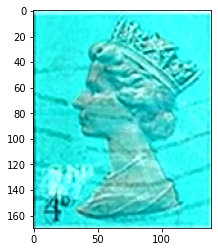

In [ ]:
# Andiamo nello spazio dei coefficienti per la base data da U
coords = np.dot(U[:,:2].T,A)

# Spostiamoci aggiungendo un offset
new_coords = coords[:,1] + [50,100]

# Torniamo nello spazio dei francobolli ricostruendo
recon = np.dot(U[:,:2], new_coords) + np.squeeze(Sm)

imr = recon.reshape(m,n,p)
imr[imr<0] = 0; imr[imr>1]=1

plt.imshow(imr)

# Procrustian problem
Un'altra applicazione interessante è quella di allineare dei dati. 

Considerate ad esempio di fare diverse foto aeree di una città e di annotare sulla foto alcuni punti che sapete essere di vostro interesse. Ora volete provare ad allineare queste foto usando i punti salienti che avete segnato, e potete ragionevolemente assumere che (se le foto sono state fatte alla stessa quota) le due differiranno per una traslazione e una rotazione.

Questo tipo di problema è chiamato anche Analisi Procrustiana Ortogonale. Vediamo come possiamo risolverla.

In questo esempio abbiamo una point cloud 2D, che ruotiamo e spostiamo.

(-0.6395386468034929,
 0.7036756929421664,
 -1.1621649884835252,
 0.5674704929920263)

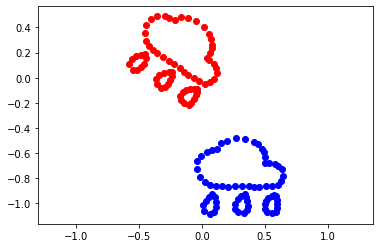

In [ ]:
# Leggiamo la point cloud
A = np.loadtxt('point_cloud.txt')

# Spostiamola e visualizziamola
A = A.T + [0, -1]
plt.scatter(A[:,0],A[:,1],color='b')

# Creiamo una matrice di rotazione 2D
theta = np.radians(34)
c, s = np.cos(theta), np.sin(theta)
R = np.array(((c, -s), (s, c)))

# Applichiamo la rotazione e spostiamo per generare una nuova point cloud
B = A @ R 
B = B +  [0,1]
plt.scatter(B[:,0],B[:,1],color='r')
plt.axis('equal')

Non andremo troppo nel dettaglio, ma si può mostrare che la traslazione ottima è quella che allinea i centri delle due point cloud, mentre la rotazione è data da $R=UV^T$ con $U, s, V^T = SVD(B^T A)$, e avremo , e avremo la rotazione ottima per l'allineamento.

Esercizio 4:
- Centrare A e B
- Calcolare la SVD per $B^T A$ centrate
- Trovare la rotazione $R$
- Applicare $R$ a $B$

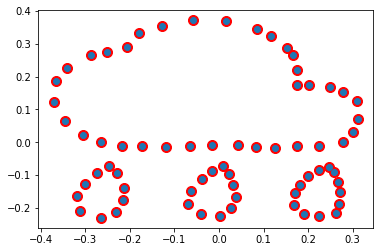

In [ ]:
# Centrare le due point clouds
B_cen = B - np.mean(B,axis=0)
A_cen = A - np.mean(A,axis=0)

# Calcolare la SVD della matrice di covarianza
u, s, vh = np.linalg.svd(B_cen.T @ A_cen)

# Recuperare la matrice ortogonale ottima (rotazione)
R_cand = u @ vh

# Applicare la rotazione a pc2
B_align = B_cen @ R_cand

# Visualizzare
plt.scatter(B_align[:,0],B_align[:,1],color='r',s=100)
plt.scatter(A_cen[:,0],A_cen[:,1])

# ICP
Nel problema appena visto però si assume di conoscere una corrispondenza iniziale: cioè sappiamo esattamente per ogni punto di una delle due point cloud dove questo dovrà andare nell'altra. Questo ci permette di calcolare la rotazione in forma chiusa. Ma se così non fosse? Se addirittura le due point cloud avessero un numero diverso di punti?

Ecco quindi che un famoso algoritmo iterativo che si basa sullo stesso princiipio è l'Iterative Closest Point (ICP). L'idea è molto semplice e questo è lo pseudo-codice:

1. M <- Point cloud da allineare (Source)
2. N <- Point cloud a cui vogliamo arrivare (Target)
3. For i in np.arange(0,#num_iterazioni):
4.   Per ogni punto di M trova il più vicino punto di N, e salvalo in una matrice di permutazione $\Pi$
5.   Risolviamo il problema procrustiano per rotazione e traslazione tra $M$ e $\Pi N$
6.   Se le point cloud sono già abbastanza vicine possiamo interrompere l'algoritmo 

Vediamo un esempio tra due point cloud prese da delle curve

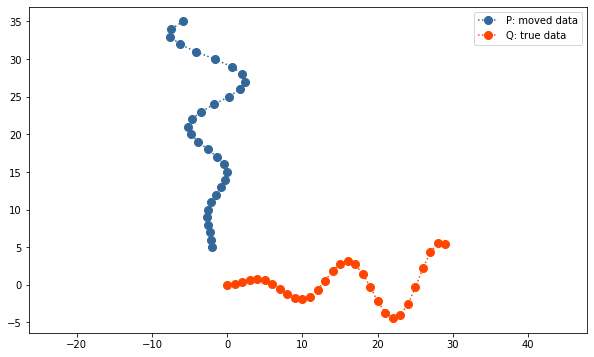

In [ ]:
def plot_data(data_1, data_2, label_1, label_2, markersize_1=8, markersize_2=8):
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    ax.axis('equal')
    if data_1 is not None:
        x_p, y_p = data_1.T
        ax.plot(x_p, y_p, color='#336699', markersize=markersize_1, marker='o', linestyle=":", label=label_1)
    if data_2 is not None:
        x_q, y_q = data_2.T
        ax.plot(x_q, y_q, color='orangered', markersize=markersize_2, marker='o', linestyle=":", label=label_2)
    ax.legend()
    return ax

angle = np.pi/2
R_true = np.array([[np.cos(angle), -np.sin(angle)], 
                   [np.sin(angle),  np.cos(angle)]])
t_true = np.array([[-2], [5]])

# Generazione dei dati
num_points = 30
A = np.zeros((2, num_points))
A[0, :] = range(0, num_points)
A[1, :] = 0.2 * A[0, :] * np.sin(0.5 * A[0, :]) 
# Move the data

num_points = 31
B = np.zeros((2, num_points))
B[0, :] = range(0, num_points)
B[1, :] = 0.2 * B[0, :] * np.sin(0.5 * B[0, :]) 
B = R_true.dot(B) + t_true

# Assign to variables we use in formulas.
Q = A.T
P = B.T

plot_data(P, Q, "P: moved data", "Q: true data")
plt.show()

In [ ]:
def draw_correspondeces(P, Q, correspondences, ax):
    label_added = False
    for i in np.arange(0,np.max(P.shape)):
        x = [P[i, 0], Q[correspondences[i],0]]
        y = [P[i, 1], Q[correspondences[i], 1]]
        if not label_added:
            ax.plot(x, y, color='grey', label='correpondences')
            label_added = True
        else:
            ax.plot(x, y, color='grey')
    ax.legend()

Esercizio 5: Scrivere una funzione che date le due point cloud $P \in \mathbb{R}^{N \times 3}$ e $Q\in \mathbb{R}^{M \times 3}$ ritorni un vettore $match$ lungo $N$ e che contenga per ogni punto $p_i$ il l'indice $j$ del punto di $Q$ più vicino (quindi $j$ può andare da $1$ a $M$).

ESEMPIO: Siano $P=\begin{bmatrix}0.95 & 0 \\ 0.8 & 0 \\ 6 & 6 \end{bmatrix}$ e $Q= \begin{bmatrix}1 & 0 \\ 5 & 5 \\ 0 & 1 \\ 0.8 & 0 \end{bmatrix}$,

  allora $match = [0, 3, 1]$

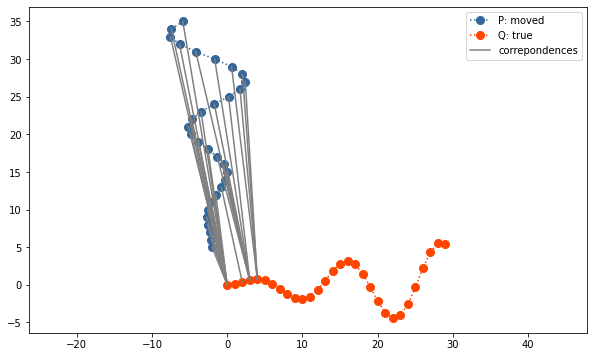

In [ ]:
from scipy.spatial import distance_matrix

def get_match(P, Q):    
  # Calcola la distanza di ogni punto di una point cloud dall'altro
  dm = distance_matrix(P, Q)

  # Salva i valori minimi lungo l'asse 1
  match = dm.argmin(axis=1)
  return match

# Ottieni match
match = get_match(P,Q)

# Visualizziamo
ax = plot_data(P, Q,
               label_1='P: moved',
               label_2='Q: true')
draw_correspondeces(P, Q, match, ax)

ESERCIZIO 6: Implementa ICP
- Ottieni la Corrispondenza tra P e Q
- Calcola la matrice di covarianza tra P e Q centrati
- Ottieni la matrice di rotazione ottima

 NOTA: Se il determinante viene negativo, allora la matrice include anche una riflessione. In quel caso, il trucco per annulare la riflessione è: `R = U @ mask @ Vt`, dove `mask = np.diag([1, 1, ..., 1, -1])`.


In [ ]:
# Teniamo traccia dell'errore
errors = []
# Dell'evoluzione della point cloud
Ps = []

# Delle corrispondenze
corres = []

P_new = P

# 10 iterazioni dovrebbero essere sufficienti
for i in np.arange(0,10):
  # Salviamo la point cloud attuale
  Ps.append(P_new)

  # Otteniamo il match tra la point cloud attuale P_new e Q
  match = get_match(P_new, Q)

  # Salviamo la corrispondenza
  corres.append(match)

  # Calcoliamo la matrice di covarianza tra P_new e Q centrate
  C = (P_new - np.mean(P_new,0)).T @ (Q[match,:] - np.mean(Q,0))

  # Otteniamo la matrice di rotazione ottima
  U, s, Vt = np.linalg.svd(C)
  R = U @ Vt 

  # Se determinante negativo, usiamo il trucchetto per annullare la riflessione
  if np.linalg.det(R) < 0 :
    mask = np.diag(np.ones(U.shape[1]-1),1)
    mask[1,1] = -1
    R = U @ mask @ Vt

  # Applichiamo la traslazione ottima
  P_new = P_new @ R
  P_new = P_new - np.mean(P_new,0) + np.mean(Q,0)

  # Salviamo
  errors.append(np.linalg.norm(P_new[0:Q.shape[0],:] - Q))

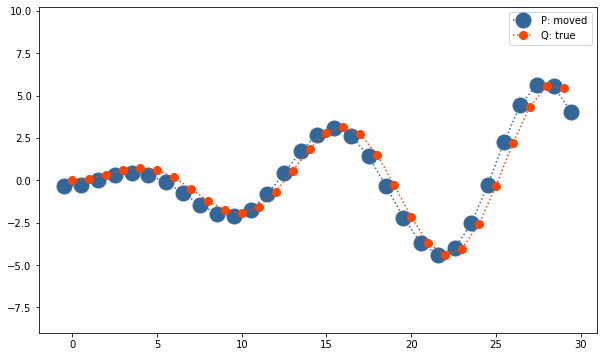

In [ ]:
ax = plot_data(P_new, Q,
               label_1='P: moved',
               label_2='Q: true', markersize_1=15)

Qui sotto potrete vedere un'animazione della vostra registrazione!

In [ ]:
def plot_values(values, label):
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(111)
    ax.plot(values, label=label)
    ax.legend()
    ax.grid(True)
    plt.show()
    
def animate_results(P_values, Q, corresp_values, xlim, ylim):
    """A function used to animate the iterative processes we use."""
    fig = plt.figure(figsize=(10, 6))
    anim_ax = fig.add_subplot(111)
    anim_ax.set(xlim=xlim, ylim=ylim)
    anim_ax.set_aspect('equal')
    plt.close()
    x_q, y_q = Q.T
    # draw initial correspondeces
    # Prepare Q data.
    Q_line, = anim_ax.plot(x_q, y_q, 'o', color='orangered')
    # prepare empty line for moved data
    P_line, = anim_ax.plot([], [], 'o', color='#336699')

    def animate(i):
        P_inc = P_values[i].T
        x_p, y_p = P_inc
        P_line.set_data(x_p, y_p)
        return (P_line,)
    
    anim = animation.FuncAnimation(fig, animate,
                                   frames=len(P_values), 
                                   interval=500, 
                                   blit=True)
    return HTML(anim.to_jshtml())
    
animate_results(Ps, Q, corres, xlim=(-20, 50), ylim=(-20, 20))

# Rimozione di BackGround da video

Vediamo ora come con SVD possiamo individuare gli oggetti in movimento in un video e rimuovere il background. Come fatto con i francobolli, in questo caso siamo interessati a togliere la parte più simile tra tutti gli elementi che compogono i nostri dati. Nel caso di un video a telecamera fissa, sarà lo sfondo.

In [ ]:
import moviepy.editor as mpe
# from IPython.display import display
from glob import glob

import sys, os
import numpy as np
import scipy

%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

!pip install pytube

In [ ]:
from pytube import YouTube
import os

def downloadYouTube(videourl, path):

    yt = YouTube(videourl)
    yt = yt.streams.filter(progressive=True, file_extension='mp4').order_by('resolution').asc().first()
    if not os.path.exists(path):
        os.makedirs(path)
    yt.download(path,filename='video.mp4')
downloadYouTube('https://www.youtube.com/watch?v=Cdld0F31FR4', './content/youtube')

os.rename("./content/youtube/video.mp4",'./110.mp4')

Carichiamo un video sintetico; altri video simili a questo possono essere trovati qui:
http://backgroundmodelschallenge.eu/

In [ ]:
# MAX_ITERS = 10
file_path = "111.mp4"

TOL = 1.0e-8

video = mpe.VideoFileClip(file_path)

video.subclip(0,1).ipython_display(width=300)
video.duration

def create_data_matrix_from_video(clip, k=5, scale=50):
    frames = []
    for i in range(k * int(clip.duration)):
      frame = rgb2gray(clip.get_frame(i/float(k))).astype(int)
      im = Image.fromarray(np.uint8(frame))
      im = im.resize((frame.shape[0]//scale,frame.shape[1]//scale),Image.ANTIALIAS)
      frames.append(np.array(im).flatten())
    return np.vstack(frames).T, (frame.shape[1]//scale,frame.shape[0]//scale)

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
def plt_images(M, A, E, index_array, dims, filename=None):
    f = plt.figure(figsize=(15, 10))
    r = len(index_array)
    pics = r * 3
    for k, i in enumerate(index_array):
        for j, mat in enumerate([M, A, E]):
            sp = f.add_subplot(r, 3, 3*k + j + 1)
            sp.axis('Off')
            pixels = mat[:,i]
            if isinstance(pixels, scipy.sparse.csr_matrix):
                pixels = pixels.todense()
            plt.imshow(np.reshape(pixels, dims), cmap='gray')
    return f
def plots(ims, dims, figsize=(15,20), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims)
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        plt.imshow(np.reshape(ims[i], dims), cmap="gray")

 96%|█████████▌| 25/26 [00:00<00:00, 207.16it/s]


Visualizziamolo

In [ ]:
from IPython.display import HTML
from base64 import b64encode
import os

# Specifica il nome del video
save_path = file_path

# Comprimi il video per la visualizzazione
compressed_path = "result_compressed.mp4"
if os.path.exists(f"{compressed_path}"):
  os.remove(f"{compressed_path}")
  
os.system(f"ffmpeg -i {save_path} -vcodec libx264 {compressed_path}")

# Mostra il video
mp4 = open(compressed_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

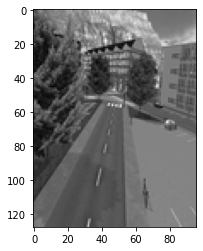

In [ ]:
scale = 5   # Aggiustiamo la scala dell'immagine per lavorare su dati più piccoli

M,dims = create_data_matrix_from_video(video, 15, scale)

plt.imshow(np.reshape(M[:,1], dims), cmap='gray');

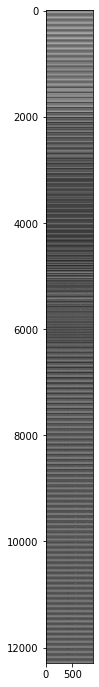

In [ ]:
# Vediamo come è fatta la matrice del video
plt.figure(figsize=(12, 12))
plt.imshow(M, cmap='gray')

Esercizio 7: 
- Calcolate il background
- Rimuovete il background da tutti i frame

In [ ]:
# Calcoliamo la SVD
u, s, v = svd(M)

# Otteniamo un'approssimazione low-rank
sigma = np.zeros((u.shape[1],v.shape[0]))
sigma[range(0,v.shape[1]),range(0,v.shape[1])] = s
sigma[sigma < s[0]] = 0
background = u @ sigma @ v

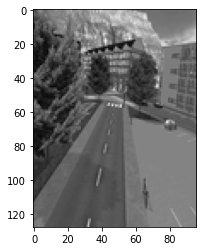

In [ ]:
# Mostriamo il frame 550
frame_num = 200
plt.imshow(np.reshape(M[:,frame_num], dims), cmap='gray');

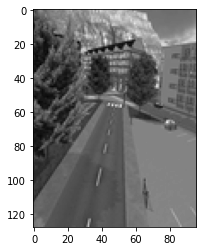

In [ ]:
# Vediamo qual è la ricostruzione del frame 550 in low_rank
plt.imshow(np.reshape(background[:,frame_num], dims), cmap='gray');

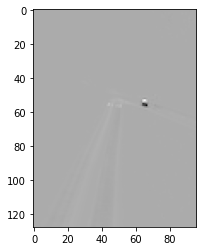

In [ ]:
# Rimuoviamo il background
plt.imshow(np.reshape(M[:,frame_num] - background[:,frame_num], dims), cmap='gray');

Visualizziamo il video ottenuto con background removal!

In [ ]:
# Possiamo generare il nuovo video
import skvideo.io
import numpy as np
frames = [np.reshape(M[:,k] - background[:,k], dims) for k in np.arange(0,M.shape[1])]
outputdata = np.array(frames)
#outputdata = (outputdata - np.min(outputdata))/(np.max(outputdata)- np.min(outputdata))
outputdata+=np.min(outputdata)
outputdata = outputdata.astype(np.uint8)

save_path = "outputvideo2.mp4"
if os.path.exists(f"{save_path}"):
  os.remove(f"{save_path}")
  
skvideo.io.vwrite("outputvideo2.mp4", outputdata)

# Visualizziamo la ricostruzione
from IPython.display import HTML
from base64 import b64encode
import os

# Input video path
save_path = "outputvideo2.mp4"

# Compressed video path
compressed_path = "output_compressed2.mp4"
if os.path.exists(f"{compressed_path}"):
  os.remove(f"{compressed_path}")
  
os.system(f"ffmpeg -i {save_path} -vcodec libx264 {compressed_path}")

# Show video
mp4 = open(compressed_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)